In [1]:
%matplotlib inline
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ['MKL_NUM_THREADS'] = '32'
# os.environ['GOTO_NUM_THREADS'] = '32'
# os.environ['OMP_NUM_THREADS'] = '32'
# os.environ['openmp'] = 'True'


import matplotlib.pyplot as plt
import matplotlib.colors as colors
import librosa
import numpy as np
import glob

import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Activation

from IPython.display import Audio
import librosa

Using TensorFlow backend.


In [65]:
stfts = []
hop_length = int(fs*0.06)
win_length = hop_length*2

for filename in glob.glob('Cuts/*.wav'):
    x,fs = librosa.load(filename, sr = None)
#     x = x[:245]
    
    stft_ = librosa.stft(x,n_fft=win_length,win_length=win_length,hop_length=hop_length ).T
    stfts.append(stft_)

stfts = np.vstack(stfts)
y = 10*np.log10(np.abs(stfts))
y = y.clip(-30)
y.shape
# plt.plot(y[4])

(180, 2647)

In [66]:
descriptors_folder = 'Descriptores-cuts/'
npys = []
for file in glob.glob(descriptors_folder+'*.npy'):
    if '_st' in file:
        x = np.load(file)
        npys.append(x)
        
X = np.hstack(npys).T
X.shape

(180, 34)

In [67]:
X_mean = X.mean(0)
X_norm = X-X_mean
X_std = X_norm.std(0)
X_norm = X_norm/X_std
X_min = X_norm.min(0)
X_norm = X_norm - X_min

print(X_norm.min(), X_norm.max())

y_mean = y.mean(0)
y_norm = y-y_mean
y_std = y_norm.std(0)
y_norm = y_norm/y_std
y_min = y_norm.min(0)
y_norm = y_norm - y_min

print(y_norm.min(), y_norm.max())

0.0 9.737482344386434
0.0 4.864184


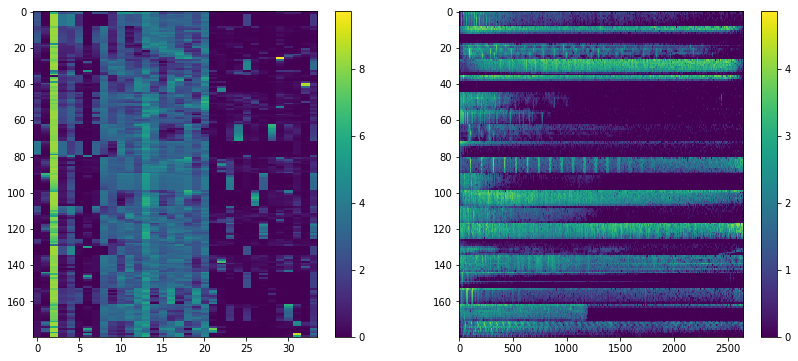

In [68]:
# X_norm = X-X.mean(0)
# X_norm = X_norm/X_norm.std(0)
# X_norm = X_norm - X_norm.min()

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(X_norm,aspect='auto')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(y_norm,aspect='auto')
plt.colorbar()

[0.00425298295966867, 0.004745246516540647, 0.007050434468934933, 0.00998840061430302]
0.005400769564116167


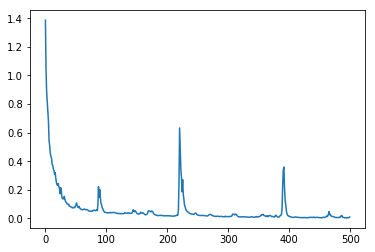

In [105]:
layers = [128,512,1024]
layers = [64,128,512]
layers = [64,128,1024]
layers = [64,128,512,1024]

kinit = keras.initializers.VarianceScaling(scale=2.0)
kinit = keras.initializers.RandomUniform()
kinit = 'normal'

binit = keras.initializers.VarianceScaling(scale=2.0)
binit = keras.initializers.RandomUniform()
binit = 'normal'

model = Sequential()
model.add(Dense(layers[0], input_dim=X.shape[1], kernel_initializer=kinit,bias_initializer=binit))
model.add(Activation('relu'))
model.add(Dense(layers[1], kernel_initializer=kinit,bias_initializer=binit))
model.add(Activation('relu'))
model.add(Dense(layers[2], kernel_initializer=kinit,bias_initializer=binit))
model.add(Activation('relu'))
model.add(Dense(layers[3], kernel_initializer=kinit,bias_initializer=binit))
model.add(Activation('relu'))
model.add(Dense(y.shape[1], kernel_initializer=kinit,bias_initializer=binit))
model.add(Activation('linear'))

optimizer = SGD(lr=0.05)
optimizer = Adam(lr = 0.001)

model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(X_norm,y_norm, batch_size=8, epochs=500, verbose=0)
plt.plot(history.history['loss'])
print(history.history['loss'][-4:])
print(np.mean(history.history['loss'][-10:]))

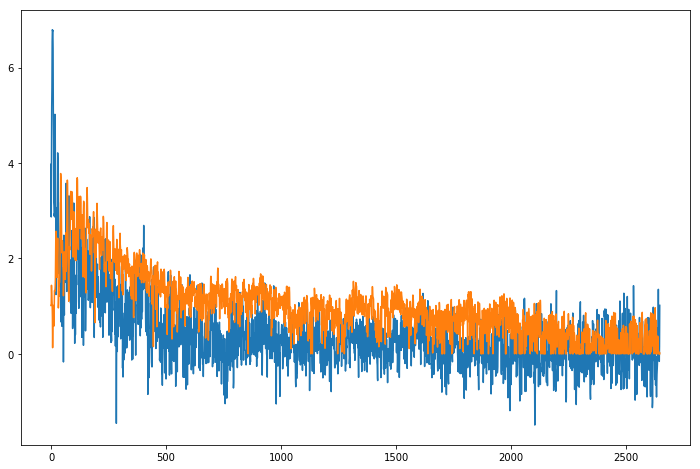

In [109]:
ix = 1
y_pred  = model.predict(X[ix:ix+1,:])
plt.figure(figsize=(12,8))
plt.plot(y_pred[0])
plt.plot(y_norm[ix,:])

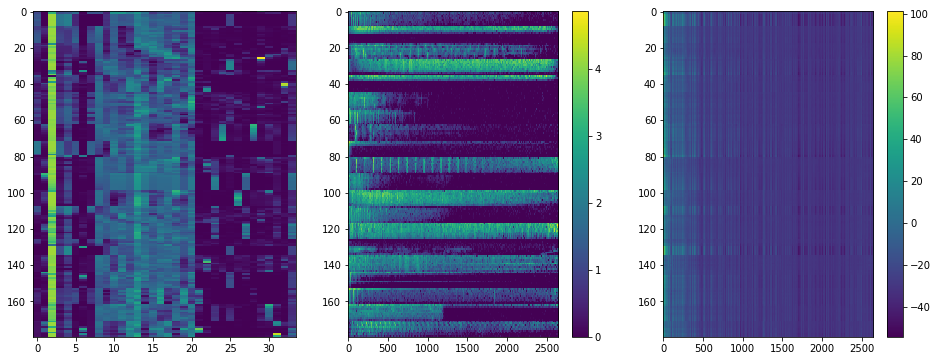

In [110]:
y_pred  = model.predict(X)
y_pred = (y_pred + y_min)*y_std+y_mean

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(X_norm,aspect='auto')
plt.subplot(1,3,2)
plt.imshow(y_norm,aspect='auto')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(y_pred,aspect='auto')
plt.colorbar()

In [112]:
y_pred  = model.predict(X)
y_pred = (y_pred + y_min)*y_std+y_mean

phase = np.random.randn(y_pred.shape[1])
S = (10**(y_pred/10.0))*np.exp(1j*phase)
out = librosa.istft(S.T,hop_length=hop_length,win_length=win_length)

In [113]:
Audio(out.real,rate=fs)

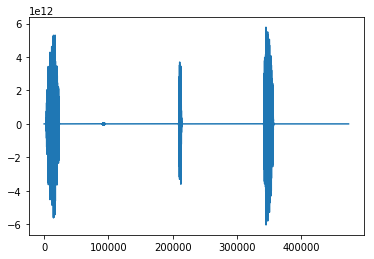

In [103]:
plt.plot(out);